In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pandas as pd
import scipy
from scipy.optimize import least_squares,differential_evolution
import time
from scipy import io
from scipy.stats import t
from scipy.signal import convolve
import tqdm
import time



In [12]:

data = scipy.io.loadmat('../data/trajectories.mat')

resp_rdw = pd.read_csv('../data/resp_rdw.csv', header=None).to_numpy().mean(axis=1)
resp_iid = pd.read_csv('../data/resp_iid.csv', header=None).to_numpy().mean(axis=1)
reslt = np.vstack([resp_iid,resp_rdw])

acc_rdw = pd.read_csv('../data/acc_rdw.csv', header=None).to_numpy().mean(axis=1)
acc_iid = pd.read_csv('../data/acc_iid.csv', header=None).to_numpy().mean(axis=1)

corrrslt = np.vstack([acc_iid,acc_rdw])

In [8]:
def getrslt(noise, nsmooth, nbias, data, indices):
    num_indices = len(indices)
    rmdl = np.zeros((2, num_indices))
    nmdl = np.zeros((2, num_indices))
    same = np.zeros((2, num_indices), dtype=bool)  # is same cond ?
    mpos = np.zeros((2, num_indices))  # mean position
    lpos = np.zeros((2, num_indices))  # last position
    n = 100
    resp = np.zeros(n)
    mdls = [0, 1]
    for j in mdls:
        traind = data['iidind'][2:, ] if j == 0 else data['rdwind'][2:, ]
        for idx, tidx in enumerate(indices):
            invis = int(traind[0, tidx])  # - 1
            pos = traind[1:, tidx].copy()
            pos[-invis + 1:] = np.nan
            lastpos = pos[-invis]  # if invis > 0 else np.nan
            lpos[j, idx] = lastpos
            meanpos = np.nanmean(pos)
            mpos[j, idx] = meanpos
            same[j, idx] = meanpos * lastpos > 0
            nmdl[j, idx] = np.sign(meanpos if j == 0 else lastpos)

            for k in range(n):
                npos = pos + np.random.randn(len(pos)) * noise + np.random.randn() * nbias
                segment = npos[-((invis) + nsmooth): -(invis - 1)]
                resp[k] = np.sign(np.mean(segment))

            rmdl[j, idx] = np.sum(resp * nmdl[j, idx] > 0) / n
    return rmdl, nmdl, same, mpos, lpos
    
def calculate_rmse_matrices(data, nsmootharr, noisearr, nbiasarr, train_indices):
    rms = np.zeros((len(nsmootharr), len(noisearr), len(nbiasarr)))
    rmsiid = np.zeros_like(rms)
    rmsrdw = np.zeros_like(rms)
    minrms = float('inf')
    best_params = None
    start_time = time.time()

    for j, ns in enumerate(nsmootharr):
        for k, no in enumerate(noisearr):
            for l, nb in enumerate(nbiasarr):
                rmdl, nmdl, same, mpos, lpos = getrslt(no, ns, nb, data, train_indices)
                rmsiid[j, k, l] = np.sqrt(np.nanmean((corrrslt[0, train_indices] - rmdl[0, :]) ** 2))
                rmsrdw[j, k, l] = np.sqrt(np.nanmean((corrrslt[1, train_indices] - rmdl[1, :]) ** 2))
                rms[j, k, l] = np.sqrt(np.nanmean((corrrslt[:, train_indices].ravel() - rmdl.ravel()) ** 2))

                if rms[j, k, l] < minrms:
                    minrms = rms[j, k, l]
                    minrmdl = rmdl
                    best_params = (ns, no, nb)

    elapsed_time = time.time() - start_time
    print("Elapsed time: {:.2f} seconds".format(elapsed_time))

    return rms, rmsiid, rmsrdw, minrms, minrmdl, best_params,same

# Function to split indices into train and test
def split_indices(indices, n_test):
    test_indices = np.random.choice(indices, n_test, replace=False)
    train_indices = np.setdiff1d(indices, test_indices)
    return train_indices, test_indices

In [5]:


idx_same_ll = np.arange(0,50)
idx_same_rr = np.arange(150,200)

idx_op_lr = np.arange(50,100)
idx_op_rl = np.arange(100,150)

_, test_same_ll = split_indices(idx_same_ll, 0)
_, test_same_rr = split_indices(idx_same_rr, 0)
_, test_op_lr = split_indices(idx_op_lr, 0)
_, test_op_rl = split_indices(idx_op_rl, 0)

test_indices = np.hstack([test_same_ll, test_same_rr, test_op_lr, test_op_rl])
train_indices = np.setdiff1d(np.hstack([idx_same_ll, idx_same_rr, idx_op_lr, idx_op_rl]), test_indices)

In [ ]:
nsmootharr = np.arange(7)
noisearr = np.arange(7)
nbiasarr = np.arange(7)

rms, rmsiid, rmsrdw, minrms, minrmdl, best_params,same = calculate_rmse_matrices(data, nsmootharr, noisearr, nbiasarr, train_indices)
print("Minimum RMSE (Train):", minrms)
print("Best parameters for minimum RMSE (Train):", best_params)

In [ ]:
# 1. nbiasarr = 0
nsmootharr = np.arange(7)

noisearr = np.arange(7)
# nbiasarr = np.arange(7)
nbiasarr = np.zeros(7)
rms_no_center_noise, rmsiid_no_center_noise, rmsrdw_no_center_noise, minrmse_no_center_noise,minrmdl_no_center_noise, best_params_no_center_noise,same = calculate_rmse_matrices(
    data, nsmootharr, noisearr, nbiasarr, train_indices
)
print("(nbiasarr = 0):")
print("Min RMSE:", minrmse_no_center_noise)
print("Best params:", best_params_no_center_noise) 

In [ ]:
# 2. noisearr = 0
nsmootharr = np.arange(7)

#noisearr = np.arange(7)
noisearr = np.zeros(7)
nbiasarr = np.arange(7)
#nbiasarr = np.zeros(7)

rms_no_noise, rmsiid_no_noise, rmsrdw_no_noise, minrmse_no_noise,minrmdl_no_noise, best_params_no_noise,same = calculate_rmse_matrices(
    data, nsmootharr, noisearr, nbiasarr, train_indices
)
print("(nbiasarr = 0):")
print("Min RMSE:", minrmse_no_noise)
print("Best params:", best_params_no_noise) 

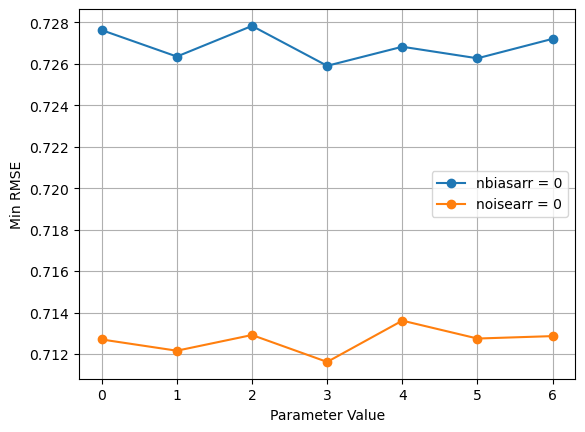

In [12]:
import matplotlib.pyplot as plt

# nbiasarr = 0
plt.plot(np.arange(7), rms_no_center_noise.min(axis=(0, 1)), marker='o', label='nbiasarr = 0')

# noisearr = 0
plt.plot(np.arange(7), rms_no_noise.min(axis=(0, 2)), marker='o', label='noisearr = 0')

plt.xlabel('Parameter Value')
plt.ylabel('Min RMSE')

plt.legend()
plt.grid()
plt.show()

In [3]:
import numpy as np

In [5]:
rmse_no_centerbias = 0.726
n = 400
rmse_no_noize = 0.712
rmse_full = 0.14

In [10]:
bic_no_cb = calculate_bic(n, rmse_no_centerbias, 2)
bic_no_noise = calculate_bic(n, rmse_no_noize, 2)
bic_full = calculate_bic(n, rmse_full, 3)
print('BIC no center bias: %.3f' % bic_no_cb)
print('BIC no noize: %.3f' % bic_no_noise)

print('BIC full: %.3f' % bic_full)

BIC no center bias: -116.099
BIC no noize: -123.888
BIC full: -768.471


In [2]:

def calculate_bic(n, mse, num_params):
	bic = n * np.log(mse) + num_params * np.log(n)
	return bic

def calculate_aic(n, mse, num_params):
	aic = n * np.log(mse) + 2 * num_params
	return aic

In [35]:
aic = calculate_aic(n, rmse_full, 2)
print('AIC: %.3f' % aic)

bic = calculate_bic(n, rmse_full, 2)
print('BIC: %.3f' % bic)

AIC: -782.445
BIC: -774.462


In [36]:
aic = calculate_aic(n, rmse_single, 1)
print('AIC: %.3f' % aic)

bic = calculate_bic(n, rmse_single, 1)
print('BIC: %.3f' % bic)

AIC: -125.948
BIC: -121.956


In [25]:
n = corrrslt.size


rmse_single = minrmse_no_center_noise  
k_single = 1  


rmse_full = 0.14
k_full = 2  


bic_single = n * np.log(rmse_single**2) + k_single * np.log(n)
bic_full = n * np.log(rmse_full**2) + k_full * np.log(n)

print("BIC (nbiasarr = 0):", bic_single)
print("BIC (all param):", bic_full)

BIC (nbiasarr = 0): -249.90435184344386
BIC (all param): -1560.9073560040501
